#  ICESat-2 L4 Monthly Gridded Sea Ice Thickness Dataset (IS2SITMOGR4)

In this notebook, we provide a basic look at the Monthly Gridded Sea Ice Thickness Dataset (IS2SITMOGR4). We will show you how to easily download the data from our public google storage bucket and how to generate some simple plots for a few variables of interest.

Raw data link: https://nsidc.org/data/is2sitmogr4/ (put in the data folder of this book if you want to avoid the goolge bucket approach we provide)

Notes: 

 - Our current focus is on this simpler, monthly gridded dataset. We hope in future efforts to showcase the hgiher-resolution along-track thickness dataset also: https://nsidc.org/data/is2sitdat4

# Import notebook dependencies

In [10]:
import xarray as xr # For working with gridded climate data 
from utils.read_data_utils import read_is2_data # Helper function for reading the data from the bucket

# Plotting dependencies
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from textwrap import wrap
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

# Read in ICESat-2 netcdf4 files using xarray
Here, we'll read in the data from the jupyter book using a function `read_is2_data` , defined in the `read_data_utils` module. You can also download this same data from the NSIDC. See the `data_wrangling` notebook for more information on this dataset.<br><br> The function loads in the data to memory as an xarray Dataset object. [xarray](http://xarray.pydata.org/en/stable/) is a python package built for working with gridded data and is particularly useful for climate data in the form of netcdf4 files 

In [2]:
print(read_is2_data.__doc__) # Print docstring

 Read in ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard dataset. 
    If the file does not already exist on the user's local drive, it is downloaded from the books google storage bucket (https://console.cloud.google.com/storage/browser/is2-pso-seaice)
    The netcdf files for each month are then read in as an xr.Dataset object
    
    Args: 
        data_dir (str, optional): name of data directory containing ICESat-2 data (default to "IS2SITMOGR4/v002", the name of the directory in the bucket)
        bucket_name (str, optional): name of google storage bucket (default to "sea-ice-thickness-data")
    Returns: 
        is2_ds (xr.Dataset): data 
    
    


In [3]:
is2_ds = read_is2_data() # Read in data
print(is2_ds) # Display the data 

<xarray.Dataset>
Dimensions:            (time: 29, y: 448, x: 304)
Coordinates:
  * time               (time) datetime64[ns] 2018-11-01 ... 2022-03-01
    longitude          (y, x) float32 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
    latitude           (y, x) float32 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
    xgrid              (y, x) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    ygrid              (y, x) float32 5.838e+06 5.838e+06 ... -5.338e+06
Dimensions without coordinates: y, x
Data variables: (12/15)
    projection         (time) float64 -2.147e+09 -2.147e+09 ... -2.147e+09
    ice_thickness      (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ice_thickness_unc  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    num_segments       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    mean_day_of_month  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    snow_depth         (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    

# Overlay sea ice thickness on a map of the Arctic 
xarray allows us to generate a quick and simple map of the data in just a few lines of code. Below, we'll plot sea ice thickness for a single month. 

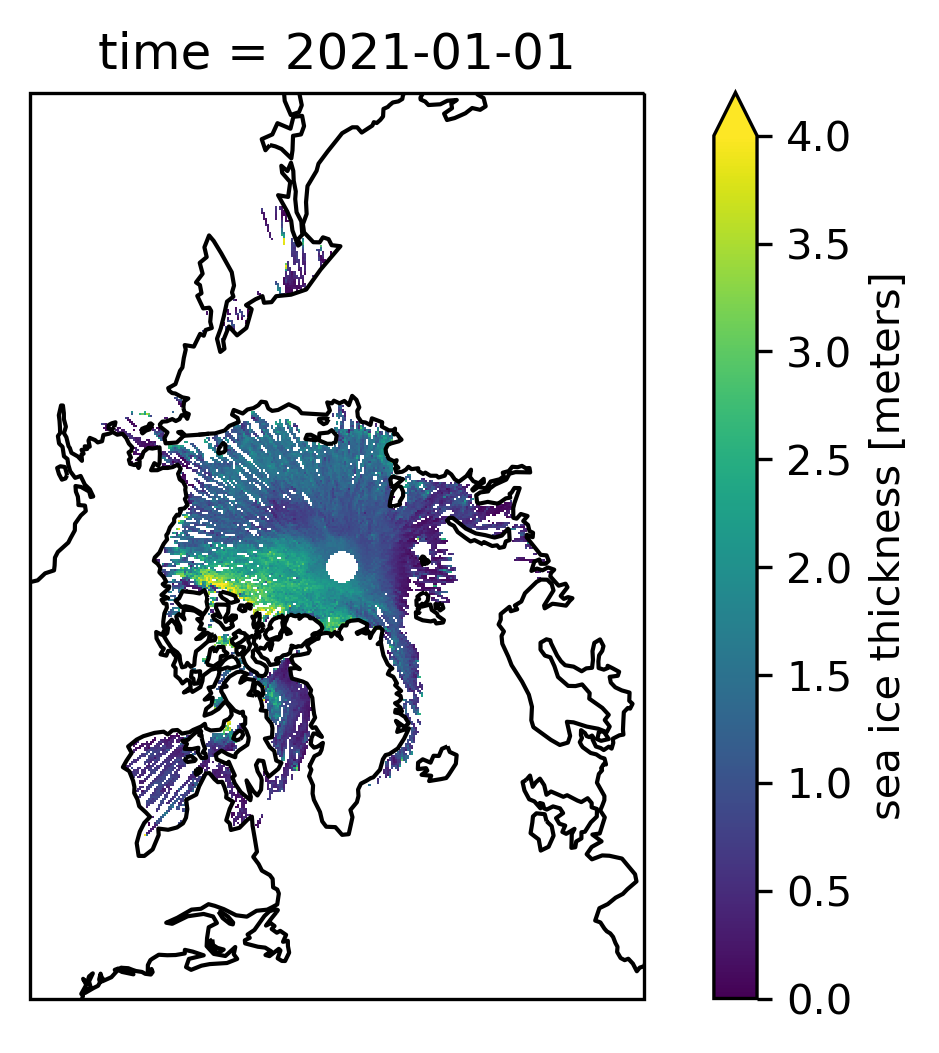

In [4]:
date = "Jan 2021"
var = "ice_thickness"
data_one_month = is2_ds[var].sel(time=date)
p = data_one_month.plot(x="longitude", y="latitude", # horizontal coordinates 
                        vmin=0, vmax=4, # min and max on the colorbar 
                        subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)}, # Set the projection 
                        transform=ccrs.PlateCarree())
p.axes.coastlines() # Add coastlines 
plt.show()

# Simple sea ice thickness maps
Using the function arguments `col` and `col_wrap`, we can modify the code for plotting one month of data to plot several months of data. Below, we'll plot sea ice thickness for Nov 2020 - Apr 2021.

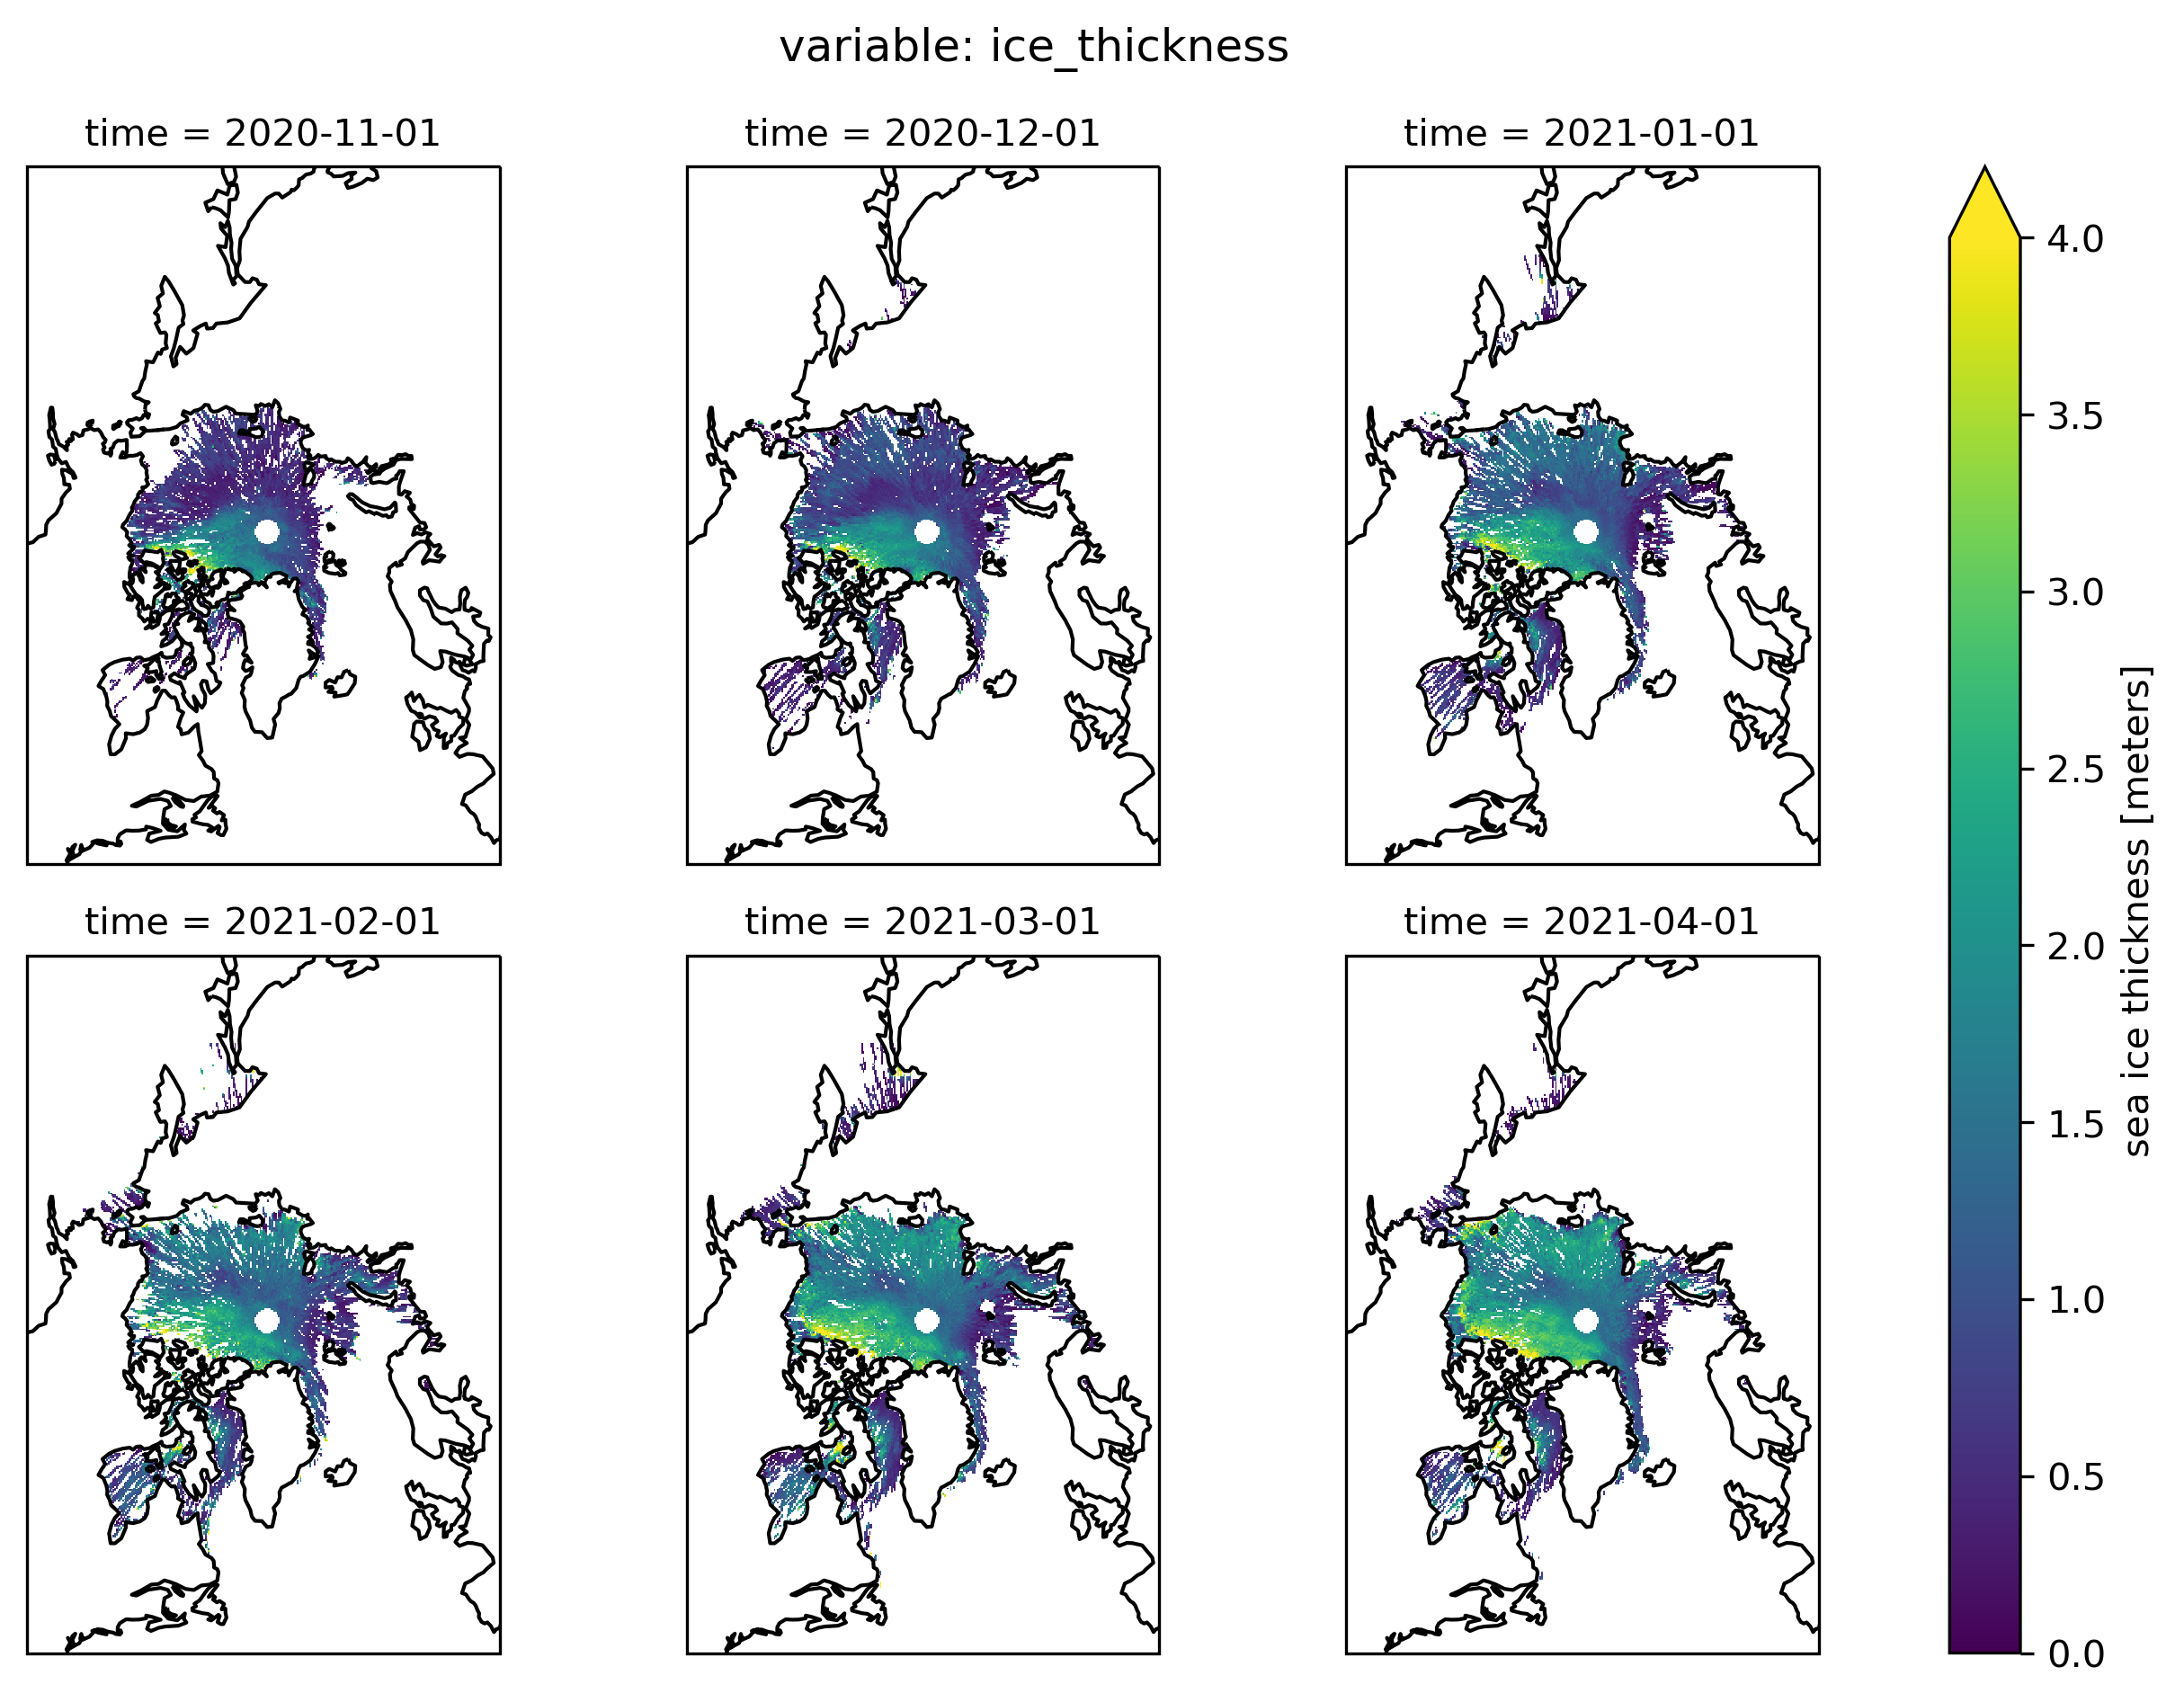

In [5]:
start_date = "Nov 2020"
end_date = "Apr 2021"
var = "ice_thickness" # Variable to use 
data_one_winter = is2_ds[var].sel(time=slice(start_date, end_date))
p = data_one_winter.plot(x="longitude", y="latitude", # Horizontal coordinates 
                         col="time", # Coordinate to use for facet grid 
                         col_wrap=3, # Number of columns to use 
                         vmin=0, vmax=4, # Min and max on the colorbar 
                         subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)}, # Set the projection 
                         transform=ccrs.PlateCarree())
for ax in p.axes.flat: # Add coastlines
    ax.coastlines()
plt.suptitle("variable: "+var, y=1.03) # Add a descriptive title
plt.show()

# Plot mean sea ice freeboard over time
Maybe we want to know how the mean has changed over time. Below, we'll compute the mean monthly sea ice freeboard for Sep 2020 - Apr 2021, and display the information in a simple lineplot. 

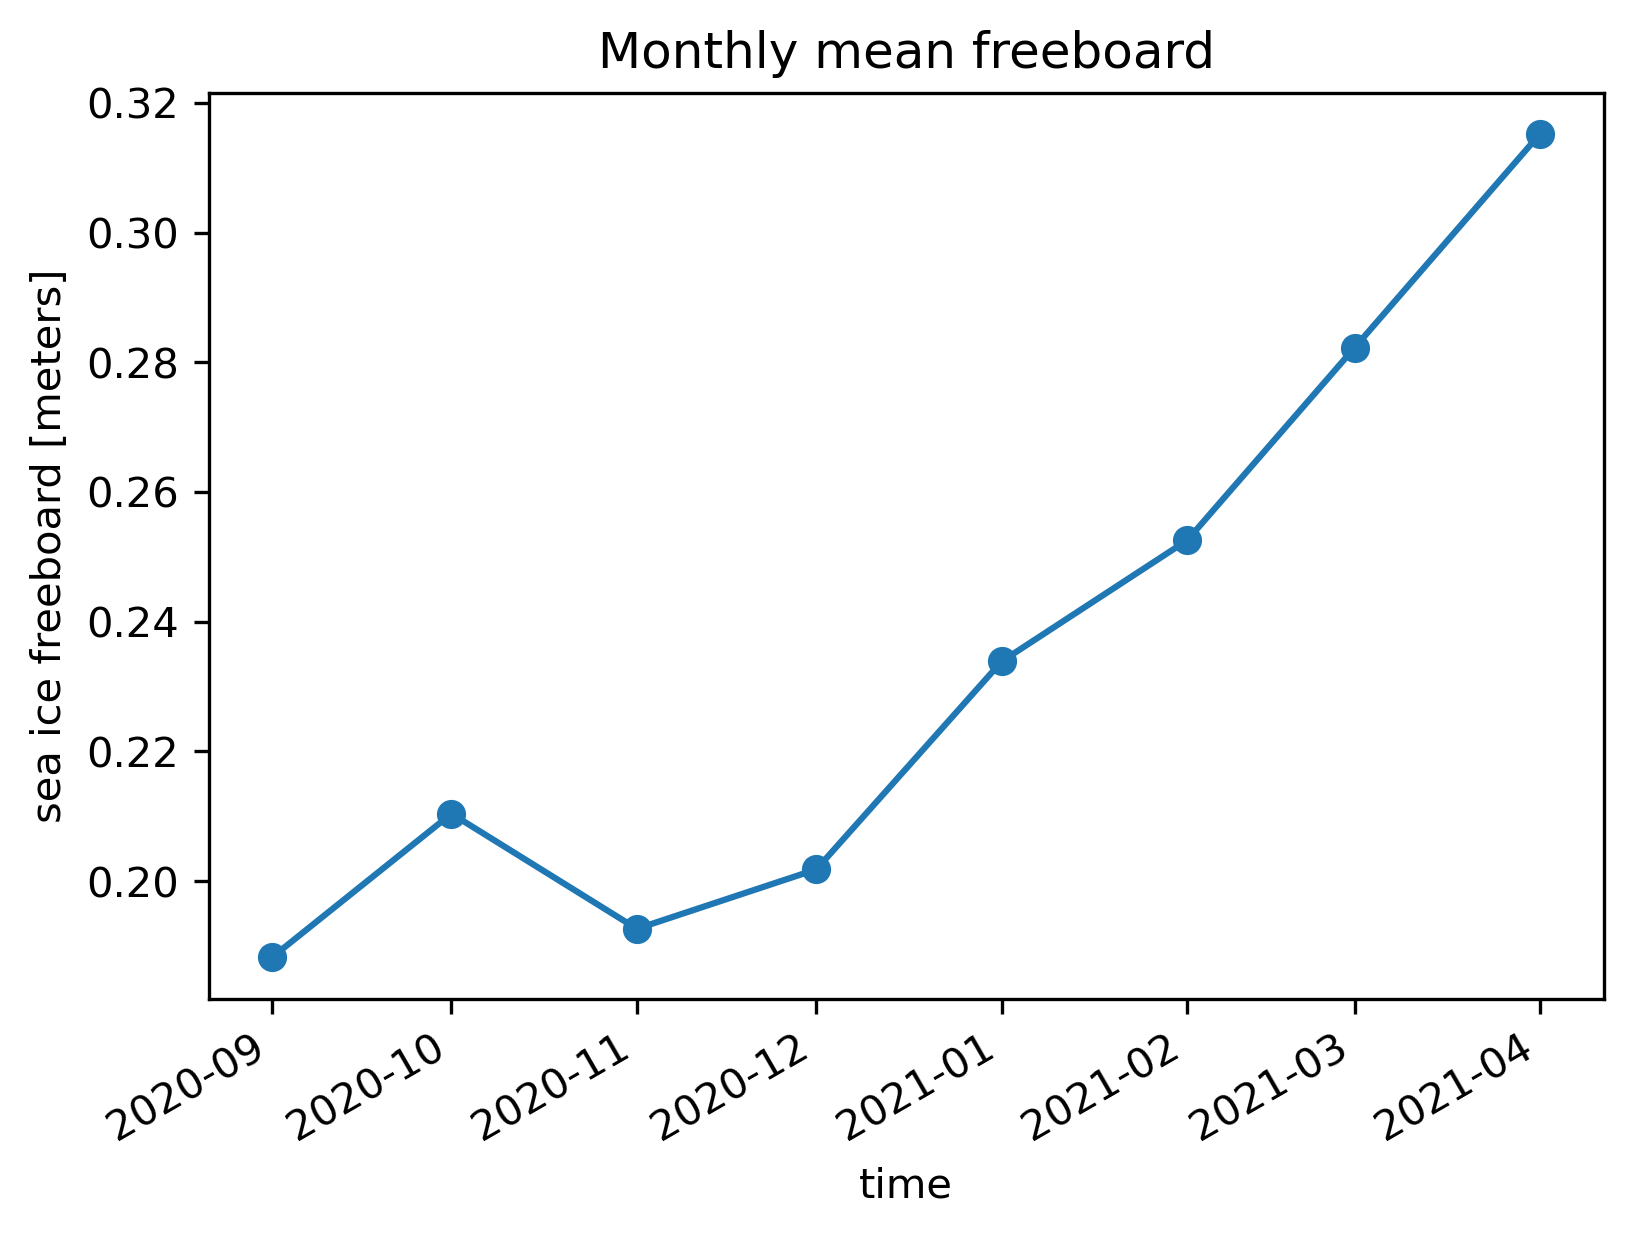

In [6]:
var = "freeboard" # Variable to use 
start_date = "Sep 2020"
end_date = "Apr 2021"
winter2020_21 = is2_ds.sel(time=slice(start_date, end_date)) # Grab data for Sep 2020 - Apr 2021
winter2020_21_mean = winter2020_21[var].mean(dim=["x","y"], # Dimensions over which to compute mean 
                                             keep_attrs=True) # Keep attributes from original dataset

lineplot = winter2020_21_mean.plot(marker='o') # Generate the lineplot 
plt.title("Monthly mean "+var) # Add a descriptive title 
plt.show()

## Restrict data to a given region
We use a region mask of the Arctic to allow us to select for regions of interest, and ignore other regions. This mask is included as a data variable in the ICESat-2 v2 data, and was provided courtesy W. Meier & S. Stewart, National Snow and Ice Data Center (NSIDC). 

In most of the analysis presented in this Jupyter Book, we restrict the data to the Inner Arctic domain, defined as the combined area of the Central Arctic, Beaufort Sea, Chukchi Sea, E Siberian Sea, Laptev Sea and Kara Sea. Freeboards and snow depths are generally more uncertain in the lower latitude peripheral seas of the Arctic.

![Arctic region mask](figs/region_mask.png "Inner Arctic region mask")

CA: Central Arctic, BS: Beaufort Sea, CS: Chukchi Sea, ESS: East Siberian Sea, LS: Laptev Sea, KS: Kara Sea, BaS: Barents Sea, EG: East Greenland Sea, GBB: Gulf of Bothnia, Baltic Sea, BB: Baffin Bay & Davis Strait, BeS: Bering Sea, SO: Sea of Okhotsk, GA: Gulf of Alaska. 


Here, we'll restrict the data to the Inner Arctic Ocean by selected the key values [1,2,3,4,5,6], corresponding to the six regions that compose the Inner Arctic Ocean. 


In [12]:
innerArctic = [1,2,3,4,5,6] #Inner Arctic Ocean
is2_ds_region_mask = is2_ds.copy()
is2_ds_region_mask = is2_ds_region_mask.where(is2_ds_region_mask.region_mask.isin(innerArctic))

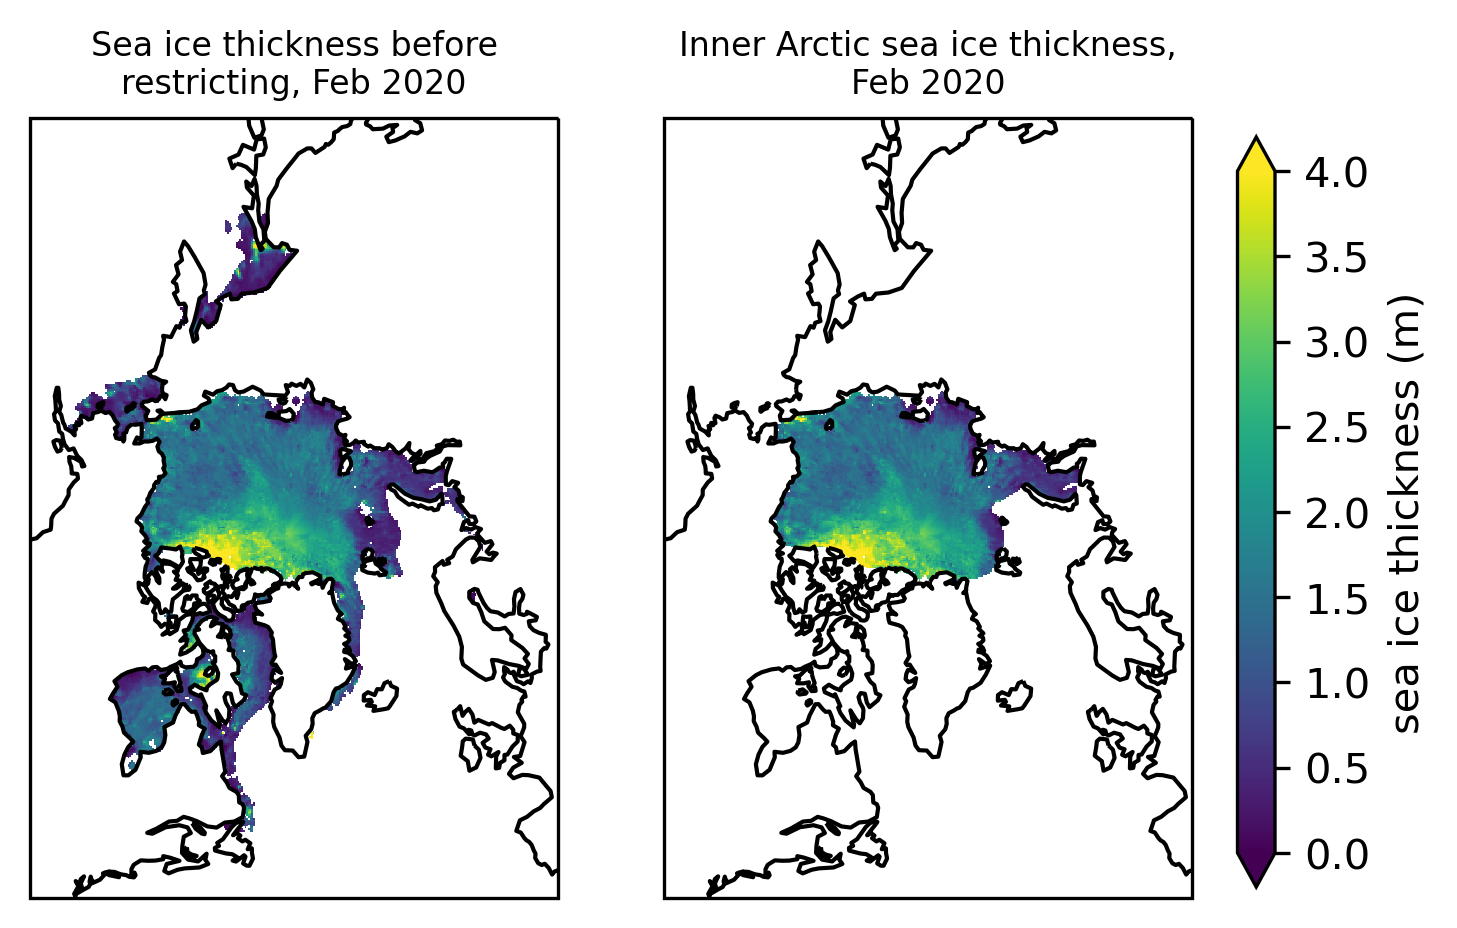

In [11]:
date = "Feb 2020"

fig, axes = plt.subplots(1, 2, figsize=(5,5), subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-45)})
im1 = is2_ds["ice_thickness_int"].sel(time=date)[0].plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', vmin=0, vmax=4, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
im2 = is2_ds_region_mask["ice_thickness_int"].sel(time=date)[0].plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', vmin=0, vmax=4, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
plt.colorbar(im1, cax=fig.add_axes([0.93, 0.25, 0.025, 0.5]), extend='both', label="sea ice thickness (m)")

axes[0].set_title("\n".join(wrap("Sea ice thickness before restricting, "+date, 32)), fontsize=8)
axes[1].set_title("\n".join(wrap("Inner Arctic Ocean sea ice thickness, "+date, 32)), fontsize=8)
axes[0].coastlines()
axes[1].coastlines()

plt.show()